In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

In [1]:
import torch
from PIL import Image
import clip
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from HF_dataset import HFDataset
import json
import os
from tqdm import tqdm
import logging
from concurrent.futures import ProcessPoolExecutor
import matplotlib.pyplot as plt
import seaborn as sns

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device)
model.to(device)
model.eval()

def encode_text(text):
    with torch.no_grad():
        text_tokens = clip.tokenize([text]).to(device)
        text_features = model.encode_text(text_tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)
    return text_features

def encode_image(image):
    with torch.no_grad():
        image_features = model.encode_image(image)
        image_features /= image_features.norm(dim=-1, keepdim=True)
    return image_features

def cosine_similarity(image_features, text_features):
    return (image_features @ text_features.T).item()

def cosine_distance(image_features, text_features):
    return 1 - cosine_similarity(image_features, text_features)


  0%|                                               | 0.00/338M [00:00<?, ?iB/s]

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 59.6MiB/s]


In [4]:
def process_samples(samples, dataset, output_file):
    distances = []
    for key in tqdm(samples, desc=f"Processing {output_file}"):
        image, text = dataset.get_by_id(key)
        image = preprocess(image).unsqueeze(0).to(device)
        image_features = encode_image(image)
        text_features = encode_text(text)
        distances.append(cosine_distance(image_features, text_features))

    with open(output_file, "w") as f:
        json.dump(distances, f)

def process_dataset(dataset_name, lookup_file):
    dataset_dir = f"data/optimized_dataset/{dataset_name}"
    if not os.path.exists(dataset_dir):
        # try another path
        dataset_dir_alt = f"/teamspace/studios/find-overlaps-in-laion-400m/data/optimized_dataset/{dataset_name}"
        if not os.path.exists(dataset_dir_alt):
            logger.warning(f"Dataset path not found: {dataset_dir_alt}")
            return
        else:
            dataset_dir = dataset_dir_alt

    try:
        with open(lookup_file, "r") as f:
            lookup = json.load(f)
    except (FileNotFoundError, json.JSONDecodeError):
        logger.warning(f"Invalid lookup file: {lookup_file}")
        return

    dataset = HFDataset(dataset_dir, "index.json", lookup)

    # Process one_copy
    one_copy_file = f"filtered_results_all/{dataset_name}-one_copy.json"
    output_one_copy = f"filtered_results_all/distances-clip/one_copy/{dataset_name}-one_copy_distances.json"

    if not os.path.exists(output_one_copy):
        if os.path.exists(one_copy_file):
            with open(one_copy_file, "r") as f:
                one_copy = json.load(f)
            process_samples(one_copy.keys(), dataset, output_one_copy)
        else:
            logger.warning(f"One copy file missing: {one_copy_file}")
    else:
        logger.info(f"Skipping processed one copy: {output_one_copy}")

    # Process multiple_copy
    multiple_copy_file = f"filtered_results_all/{dataset_name}-multiple_copy.json"
    output_multiple_copy = f"filtered_results_all/distances-clip/multiple_copy/{dataset_name}-multiple_copy_distances.json"

    if not os.path.exists(output_multiple_copy):
        if os.path.exists(multiple_copy_file):
            with open(multiple_copy_file, "r") as f:
                multiple_copy = json.load(f)
            process_samples(multiple_copy.keys(), dataset, output_multiple_copy)
        else:
            logger.warning(f"Multiple copy file missing: {multiple_copy_file}")
    else:
        logger.info(f"Skipping processed multiple copy: {output_multiple_copy}")

In [5]:
    dataset_names = ["imagenet-a", "imagenet-o","imagenet-r", "cifar100", "caltech101", "cars", "aircraft", "country211", "fer2013", "food101", "imagenetv2", "pets", "sun397"]
    dataset_list = [(dataset_name, f"data/classes_{dataset_name}.json") for dataset_name in dataset_names]
    lookup_files = [f"classes_{name}.json" for name in dataset_list]
    splits = ["train", "test"]

    for dataset_name, lookup_file in dataset_list:
        for split in splits:
            process_dataset(f"{dataset_name}-{split}", lookup_file)

2025-03-05 14:55:44,033 - WARNING - Dataset path not found: /teamspace/studios/find-overlaps-in-laion-400m/data/optimized_dataset/imagenet-a-train
Processing filtered_results_all/distances-clip/one_copy/imagenet-a-test-one_copy_distances.json: 100%|██████████| 24/24 [00:06<00:00,  3.68it/s]
Processing filtered_results_all/distances-clip/multiple_copy/imagenet-a-test-multiple_copy_distances.json: 100%|██████████| 8/8 [00:01<00:00,  4.22it/s]
2025-03-05 14:55:52,663 - WARNING - Dataset path not found: /teamspace/studios/find-overlaps-in-laion-400m/data/optimized_dataset/imagenet-o-train
Processing filtered_results_all/distances-clip/one_copy/imagenet-o-test-one_copy_distances.json: 100%|██████████| 44/44 [00:11<00:00,  3.95it/s]
Processing filtered_results_all/distances-clip/multiple_copy/imagenet-o-test-multiple_copy_distances.json: 100%|██████████| 19/19 [00:04<00:00,  4.13it/s]
2025-03-05 14:56:08,625 - WARNING - Dataset path not found: /teamspace/studios/find-overlaps-in-laion-400m/d

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import glob

# Example distances
def distance_histogram_by_dataset(dataset_name, output_dir):

    one_files = glob.glob(f"filtered_results_all/distances/one_copy/{dataset_name}*.json")
    distances_one = []
    for file in one_files:
        with open(file, "r") as f:
            data = json.load(f)
            if isinstance(data, list):
                distances_one.extend(data)
            else:
                print(f"Warning! {file} does not contain a list.")

    multiple_files = glob.glob(f"filtered_results_all/distances/multiple_copy/{dataset_name}*.json")
    distances_multiple = []
    for file in multiple_files:
        with open(file, "r") as f:
            data = json.load(f)
            if isinstance(data, list):
                distances_multiple.extend(data)
            else:
                print(f"Warning! {file} does not contain a list.")

    bins = np.linspace(min(min(distances_one), min(distances_multiple)), max(max(distances_one), max(distances_multiple)), 50)

    plt.hist(distances_one, bins=bins, alpha=0.5, label="has one copy in laion400m", color='blue', edgecolor='black', density=True)
    plt.hist(distances_multiple, bins=bins, alpha=0.5, label="has multiple copy in laion400m", color='red', edgecolor='black', density=True)

    plt.xlabel("Cosine Distance")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of Image-Text Cosine Distances in {dataset_name}")
    plt.legend()

    save_path = os.path.join(output_dir, f'{dataset_name}.png')
    plt.savefig(save_path)
    plt.close()

save_dir = "figures/histograms"
os.makedirs(save_dir, exist_ok=True)
dataset_names = ["imagenet-a", "imagenet-o","imagenet-r", "cifar100", "caltech101", "cars", "aircraft", "country211", "fer2013", "food101", "imagenetv2", "pets", "sun397"]
for name in tqdm(dataset_names):
    distance_histogram_by_dataset(name, save_dir)

100%|██████████| 13/13 [00:02<00:00,  4.91it/s]


Total items in one_copy 5018
Total items in multiple_copy 2959


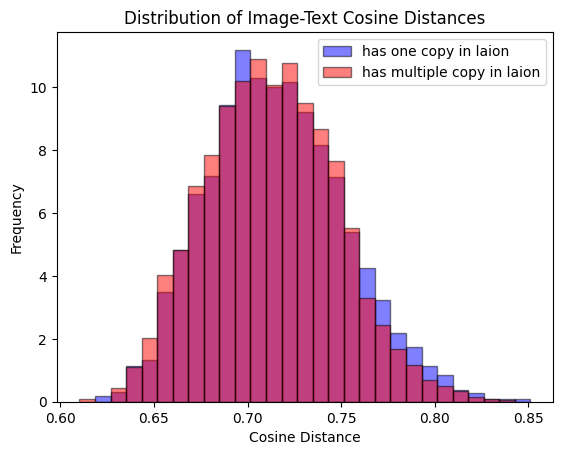

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import numpy as np
import glob

def get_copy_distance(copy_type):
    copy_path = f"/teamspace/studios/this_studio/filtered_results_all/distances-clip/{copy_type}"
    distance_files = glob.glob(os.path.join(copy_path, "*.json"))
    distances = []
    for file in distance_files:
        with open(file, "r") as f:
            data = json.load(f)
            if isinstance(data, list):
                distances.extend(data)
            else:
                print(f"Warning! {file} does not contain a list.")
    print(f"Total items in {copy_type}", len(distances))
    return distances

distance_one_copy = get_copy_distance("one_copy")
distance_multiple_copy = get_copy_distance("multiple_copy")

bins = np.linspace(min(min(distance_one_copy), min(distance_multiple_copy)), max(max(distance_one_copy), max(distance_multiple_copy)), 30)

plt.hist(distance_one_copy, bins=bins, alpha=0.5, label="has one copy in laion", color='blue', edgecolor='black', density=True)
plt.hist(distance_multiple_copy, bins=bins, alpha=0.5, label="has multiple copy in laion", color='red', edgecolor='black', density=True)

# # Add KDE curves for both datasets
# sns.kdeplot(distance_one_copy, color='blue', label="KDE for one copy", linewidth=2)
# sns.kdeplot(distance_multiple_copy, color='red', label="KDE for multiple copies", linewidth=2)

# Plot histogram
# sns.histplot(cosine_distances, bins=50, kde=True)
plt.xlabel("Cosine Distance")
plt.ylabel("Frequency")
plt.title("Distribution of Image-Text Cosine Distances")
plt.legend()
plt.show()
